In [248]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
weather = "/content/gdrive/My Drive/datasci/weather.csv"
room = "/content/gdrive/My Drive/datasci/room.csv"

Mounted at /content/gdrive


In [249]:
import pandas as pd
import datetime

In [250]:
weather_df = pd.read_csv(weather)
room_df = pd.read_csv(room)

#remove unused variables
weather_df = weather_df.drop(["phenomenon", "precipitations", "windSpeedMax", "windDirection", "windSpeed"], axis=1)
room_df = room_df.drop(["feel", "home", "humid"], axis=1)

#since window was never fully open, replace it with a binary value (0 - closed, 1 - open)
room_df["window"] = (room_df['window'].isin(["open","partial"]))

#make ts to true datetime
room_df["ts"] = pd.to_datetime(room_df['ts'])
weather_df["ts"] = pd.to_datetime(weather_df['ts'])

#get rid of every room temp before 2021-11-27 10:00:00 (otherwise we don't have weather data)
room_df = room_df[room_df['ts'] >= datetime.datetime(year=2021, month=11, day=27, hour=10)].reset_index(drop=True)

In [251]:
room_df

,ts,temp,rad,window
0,2021-11-27 10:00:02,25.1,3.5,False
1,2021-11-27 10:02:02,25.1,3.5,False
2,2021-11-27 10:04:01,25.1,3.5,False
3,2021-11-27 10:06:02,25.1,3.5,False
4,2021-11-27 10:08:02,25.1,3.5,False
...,...,...,...,...
13117,2021-12-15 23:46:02,25.3,3.5,False
13118,2021-12-15 23:48:02,25.3,3.5,False
13119,2021-12-15 23:50:01,25.3,3.5,False
13120,2021-12-15 23:52:02,25.3,3.5,False


In [252]:
#join weather and room dataframes into 1

lastworking = None
def get_weather(roomTs):
    global lastworking
    try:
        a = weather_df[weather_df["ts"] == roomTs.replace(microsecond=0, second=0, minute=0)].drop("ts", axis=1).reset_index(drop=True)
        lastworking = list(a.loc[0])
        return lastworking
        
    #in some rare cases weather info doesn't exist, use previous
    except:
        return lastworking

df = pd.DataFrame(columns=['ts', 'roomTemp', 'rad', 'window', 'outTemp', 'outHumid', 'outPressure'])
for i, e in enumerate(room_df.iterrows()):
    df.loc[i] = list(room_df.loc[i]) + get_weather(room_df.loc[i]["ts"])

Create a graph of inside vs outside temp

In [253]:
time = list()
outTemp = list()
inTemp = list()
window = list()
rad = list()

for i, u in enumerate(room_df.iterrows()):
    e = df.iloc[i]
    time.append(e["ts"])
    outTemp.append(float(e["outTemp"]))
    inTemp.append(float(e["roomTemp"]))
    window.append(float(e["window"]))
    rad.append(float(e["rad"]))

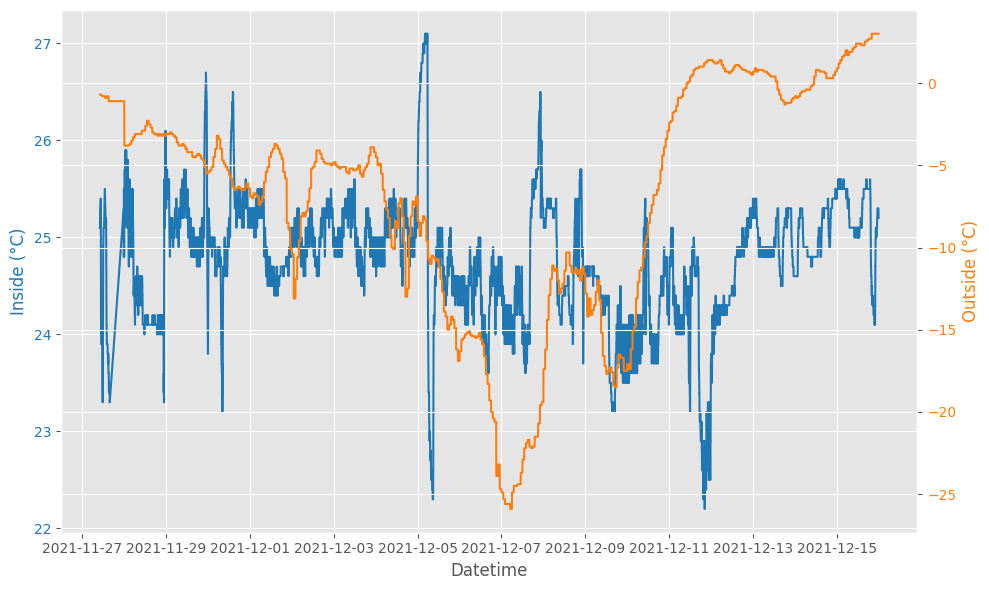

In [254]:
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=100)

color = 'tab:blue'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Inside (°C)', color=color)
ax1.plot(time, inTemp, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Outside (°C)', color=color)  # we already handled the x-label with ax1
ax2.plot(time, outTemp, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Train the model

In [255]:
minuteVar = 16

1. get all instances of opening window

In [256]:
#split to separate series
dfo = df[df["window"] == True].reset_index(drop=True)

seriesOW = list()

counter = 0
minCounter = 0
first = True
initial_temp = 0
for i, e in enumerate(df.iterrows()):
    if first:
        dfe = pd.DataFrame(columns=['ts', 'roomTemp', 'rad', 'window', 'outTemp', 'outHumid', 'outPressure', 'minutes', 'isWindowChange', 'isRadChange'])
        first = False
        initial_temp = dfo.iloc[i]["roomTemp"]
    
    try:
        if minCounter <= minuteVar:
            ndf = dfo.iloc[i]
            ndf["minutes"] = minCounter
            ndf["isWindowChange"] = -1
            ndf["isRadChange"] = 0
            ndf["tempChange"] = ndf["roomTemp"] - initial_temp
            dfe = dfe.append(ndf, ignore_index=True)
            minCounter+=2

            
        if dfo.iloc[i+1]["ts"] - dfo.iloc[i]["ts"] > datetime.timedelta(minutes=3):
            first = True
            minCounter = 0
            seriesOW.append(dfe)
            counter += 1
    except:
        pass


print(len(seriesOW))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21:

11


graph all open windows

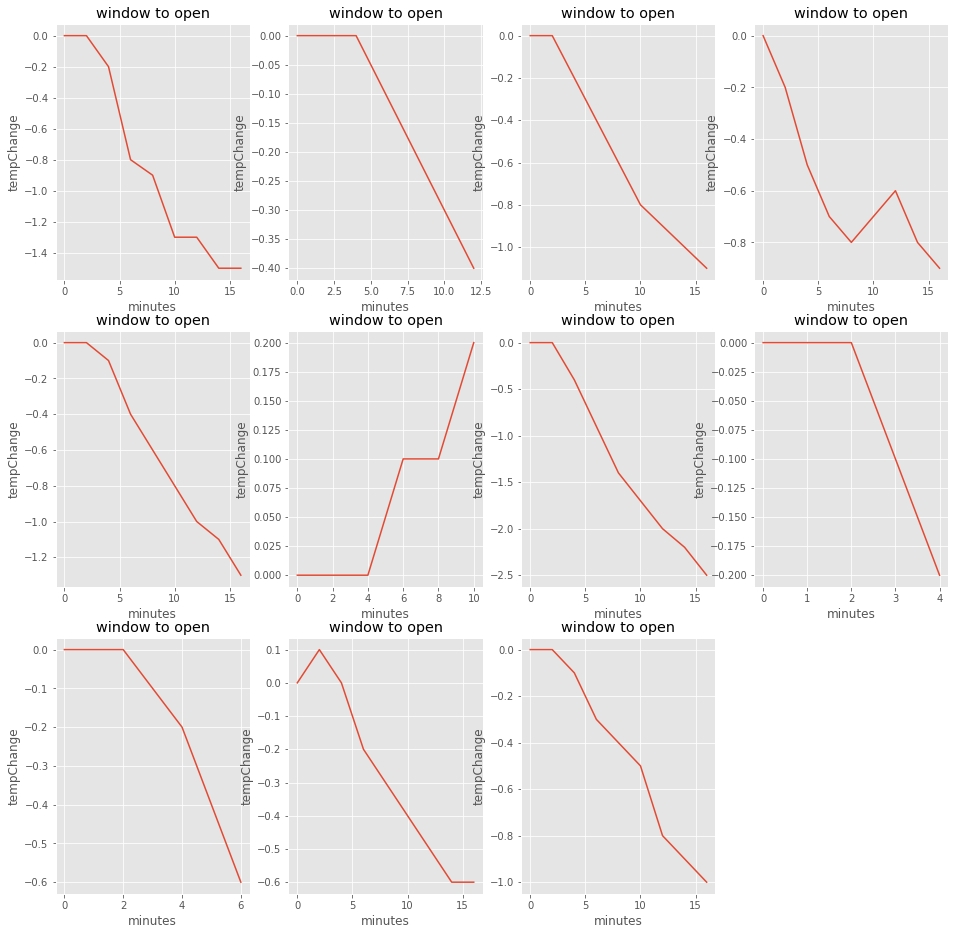

In [257]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')


plt.figure(figsize=(16,16))
for i in range(len(seriesOW)):
    plt.subplot(3,4,i+1)  # 3: number of rows, 4: number of columns, 1: index of the plot (starting from 1), total 12 indices
    plt.title("window to open")
    sns.lineplot(data=seriesOW[i], x="minutes", y="tempChange")

2. get all instances of closing window

In [258]:
#split to separate series
dfo = df[df["window"] == False].reset_index(drop=True)

seriesCW = list()

counter = 0
minCounter = 0
first = True
initial_temp = 0
for i, e in enumerate(df.iterrows()):
    if first:
        dfe = pd.DataFrame(columns=['ts', 'roomTemp', 'rad', 'window', 'outTemp', 'outHumid', 'outPressure', 'minutes', 'isWindowChange', 'isRadChange'])
        first = False
        initial_temp = dfo.iloc[i]["roomTemp"]
    
    try:
        if minCounter <= minuteVar:
            ndf = dfo.iloc[i]
            ndf["minutes"] = minCounter
            ndf["isWindowChange"] = 1
            ndf["isRadChange"] = 0
            ndf["tempChange"] = ndf["roomTemp"] - initial_temp
            dfe = dfe.append(ndf, ignore_index=True)
            minCounter+=2

            
        if dfo.iloc[i+1]["ts"] - dfo.iloc[i]["ts"] > datetime.timedelta(minutes=3):
            first = True
            minCounter = 0
            seriesCW.append(dfe)
            counter += 1
    except:
        pass


print(len(seriesCW))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21:

12


show all close window graphs

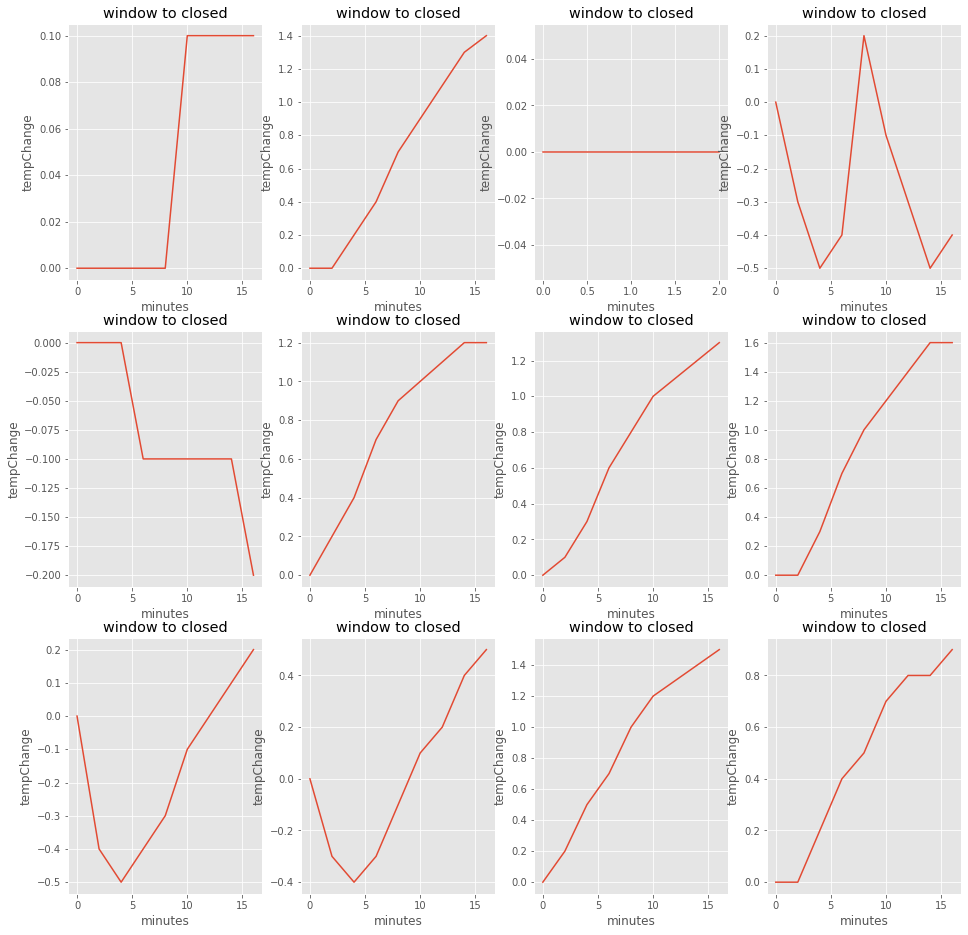

In [259]:
plt.figure(figsize=(16,16))
for i in range(len(seriesCW)):
    plt.subplot(3,4,i+1)  # 3: number of rows, 4: number of columns, 1: index of the plot (starting from 1), total 12 indices
    plt.title("window to closed")
    sns.lineplot(data=seriesCW[i], x="minutes", y="tempChange")

do same for radiator change (normal - 3.5)

In [260]:
#split to separate series
dfo = df[df["rad"] < 4].reset_index(drop=True)

seriesNR = list()

counter = 0
minCounter = 0
first = True
initial_temp = 0
for i, e in enumerate(df.iterrows()):
    if first:
        dfe = pd.DataFrame(columns=['ts', 'roomTemp', 'rad', 'window', 'outTemp', 'outHumid', 'outPressure', 'minutes', 'isWindowChange', 'isRadChange'])
        first = False
        initial_temp = dfo.iloc[i]["roomTemp"]
    
    try:
        if minCounter <= minuteVar:
            ndf = dfo.iloc[i]
            ndf["minutes"] = minCounter
            ndf["isWindowChange"] = 0
            ndf["isRadChange"] = -1
            ndf["tempChange"] = ndf["roomTemp"] - initial_temp
            dfe = dfe.append(ndf, ignore_index=True)
            minCounter+=2

            
        if dfo.iloc[i+1]["ts"] - dfo.iloc[i]["ts"] > datetime.timedelta(minutes=3):
            first = True
            minCounter = 0
            seriesNR.append(dfe)
            counter += 1
    except:
        pass


print(len(seriesNR))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21:

6


graph rad getting turned to normal

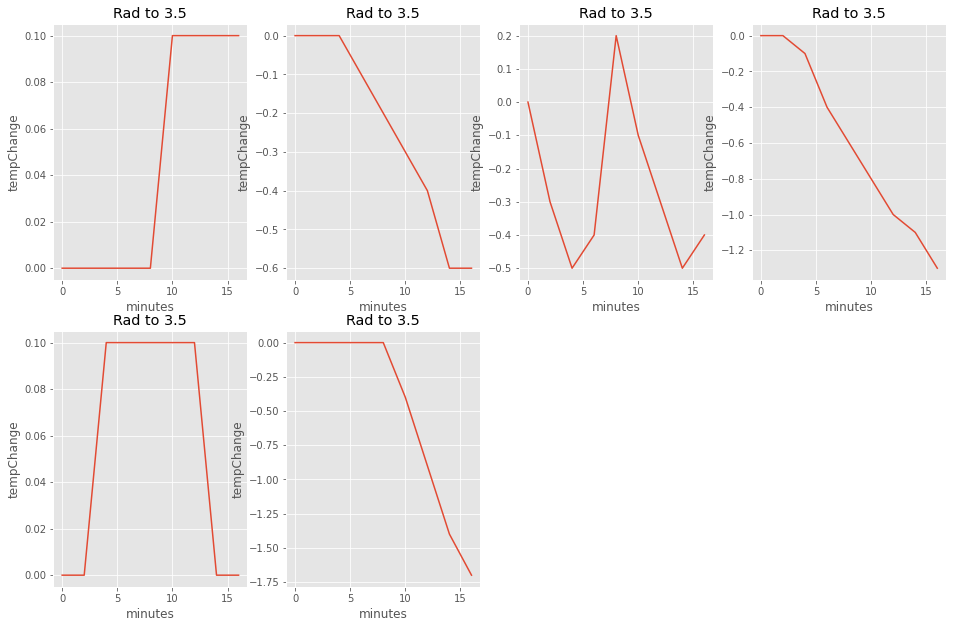

In [261]:
plt.figure(figsize=(16,16))
for i in range(len(seriesNR)):
    plt.subplot(3,4,i+1)  # 3: number of rows, 4: number of columns, 1: index of the plot (starting from 1), total 12 indices
    plt.title("Rad to 3.5")
    sns.lineplot(data=seriesNR[i], x="minutes", y="tempChange")

radiator changes (to 5)

In [262]:
#split to separate series
dfo = df[df["rad"] > 4].reset_index(drop=True)

seriesHR = list()

counter = 0
minCounter = 0
first = True
initial_temp = 0
for i, e in enumerate(df.iterrows()):
    if first:
        dfe = pd.DataFrame(columns=['ts', 'roomTemp', 'rad', 'window', 'outTemp', 'outHumid', 'outPressure', 'minutes', 'isWindowChange', 'isRadChange'])
        first = False
        initial_temp = dfo.iloc[i]["roomTemp"]
    
    try:
        if minCounter <= minuteVar:
            ndf = dfo.iloc[i]
            ndf["minutes"] = minCounter
            ndf["isWindowChange"] = 0
            ndf["isRadChange"] = 1
            ndf["tempChange"] = ndf["roomTemp"] - initial_temp
            dfe = dfe.append(ndf, ignore_index=True)
            minCounter+=2

            
        if dfo.iloc[i+1]["ts"] - dfo.iloc[i]["ts"] > datetime.timedelta(minutes=3):
            first = True
            minCounter = 0
            seriesHR.append(dfe)
            counter += 1
    except:
        pass


print(len(seriesHR))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21:

3


graph

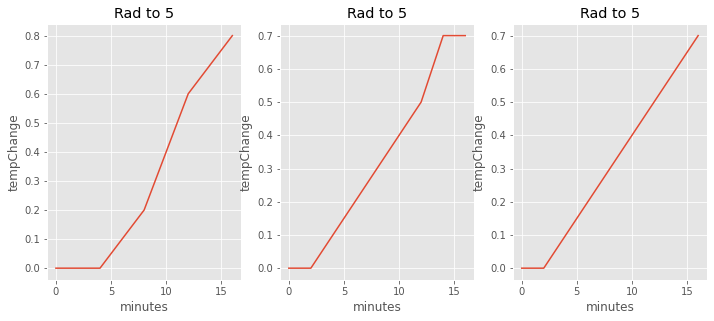

In [263]:
plt.figure(figsize=(16,16))
for i in range(len(seriesHR)):
    plt.subplot(3,4,i+1)  # 3: number of rows, 4: number of columns, 1: index of the plot (starting from 1), total 12 indices
    plt.title("Rad to 5")
    sns.lineplot(data=seriesHR[i], x="minutes", y="tempChange")

MERGE all series together (concat)

In [264]:
conOW = pd.concat([x for x in seriesOW])
conCW = pd.concat([x for x in seriesCW])
conNR = pd.concat([x for x in seriesNR])
conHR = pd.concat([x for x in seriesHR])
data = pd.concat([conOW,conCW,conNR,conHR])
data

,ts,roomTemp,rad,window,outTemp,outHumid,outPressure,minutes,isWindowChange,isRadChange,tempChange
0,2021-11-27 10:30:01,25.4,3.5,True,-0.7,94.0,1000.8,0,-1,0,0.0
1,2021-11-27 10:32:02,25.4,3.5,True,-0.7,94.0,1000.8,2,-1,0,0.0
2,2021-11-27 10:34:01,25.2,3.5,True,-0.7,94.0,1000.8,4,-1,0,-0.2
3,2021-11-27 10:36:01,24.6,3.5,True,-0.7,94.0,1000.8,6,-1,0,-0.8
4,2021-11-27 10:38:02,24.5,3.5,True,-0.7,94.0,1000.8,8,-1,0,-0.9
...,...,...,...,...,...,...,...,...,...,...,...
4,2021-12-05 00:04:02,25.5,5.0,False,-8.4,93.0,1010.5,8,0,1,0.3
5,2021-12-05 00:06:02,25.6,5.0,False,-8.4,93.0,1010.5,10,0,1,0.4
6,2021-12-05 00:08:01,25.7,5.0,False,-8.4,93.0,1010.5,12,0,1,0.5
7,2021-12-05 00:10:02,25.8,5.0,False,-8.4,93.0,1010.5,14,0,1,0.6


# Train & Predict

fit model

In [265]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel="rbf", C=0.1, gamma=0.1, epsilon=0.1)
rbf = svr_rbf.fit(data.drop(["ts", "roomTemp", "tempChange"], axis=1), data["tempChange"])

Create artificial window opening event

In [266]:
# create artificial data to predict from, with 16min

samps = list()

real = df.sample(n=10, random_state=1).drop(["ts"], axis=1).reset_index(drop=True)

for i, e in enumerate(real.iterrows()):
    samp = real.iloc[i].drop(["roomTemp"])
    minCounter = 0
    art = pd.DataFrame(columns=['rad', 'window', 'outTemp', 'outHumid', 'outPressure', 'minutes',  'isWindowChange', 'isRadChange'])
    for u in range(1,9):
        ndf = samp
        ndf["window"] = True
        ndf["isWindowChange"] = -1
        ndf["isRadChange"] = 0
        ndf["minutes"] = u*2
        art = art.append(ndf, ignore_index=True)
        
    samps.append(art)

samps[0].head()

,rad,window,outTemp,outHumid,outPressure,minutes,isWindowChange,isRadChange
0,3.5,True,1.3,94.0,1018.6,2,-1,0
1,3.5,True,1.3,94.0,1018.6,4,-1,0
2,3.5,True,1.3,94.0,1018.6,6,-1,0
3,3.5,True,1.3,94.0,1018.6,8,-1,0
4,3.5,True,1.3,94.0,1018.6,10,-1,0


predict & graph

[ 0.00763679  0.00494251 -0.04221146 -0.09787095 -0.13879507 -0.16011041
 -0.15869782 -0.12866686]


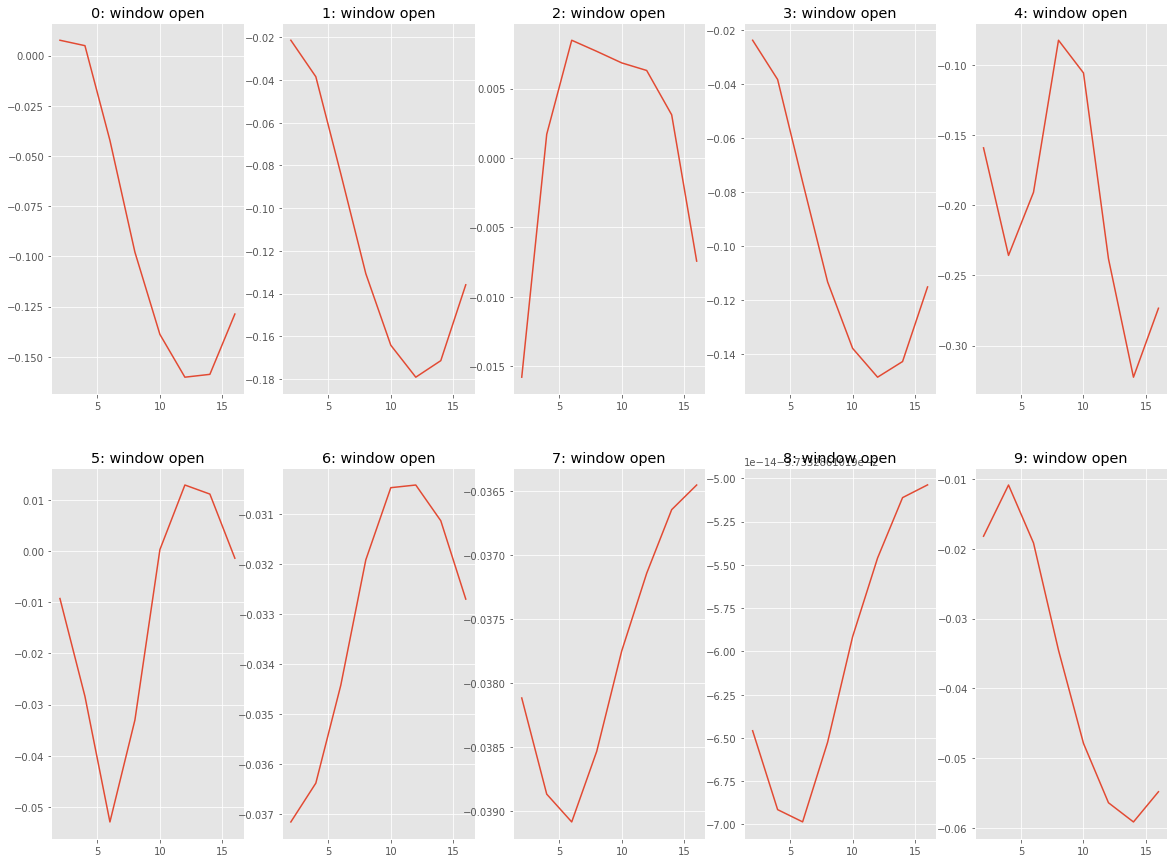

In [267]:
preds = list()
for i in range(10):
    p = rbf.predict(samps[i])
    preds.append(p)

print(preds[0])

plt.figure(figsize=(20,15))

for e in range(10):
    plt.subplot(2,5,e+1)  # 3: number of rows, 4: number of columns, 1: index of the plot (starting from 1), total 12 indices
    plt.title(f"{e}: window open")
    sns.lineplot(x=[2,4,6,8,10,12,14,16], y=preds[e])

Create artificial window closing event

In [268]:
# create artificial data to predict from, with 16min

samps = list()

real = df.sample(n=10, random_state=1).drop(["ts"], axis=1).reset_index(drop=True)

for i, e in enumerate(real.iterrows()):
    samp = real.iloc[i].drop(["roomTemp"])
    minCounter = 0
    art = pd.DataFrame(columns=['rad', 'window', 'outTemp', 'outHumid', 'outPressure', 'minutes',  'isWindowChange', 'isRadChange'])
    for u in range(1,9):
        ndf = samp
        ndf["window"] = False
        ndf["isWindowChange"] = 1
        ndf["isRadChange"] = 0
        ndf["minutes"] = u*2
        art = art.append(ndf, ignore_index=True)
        
    samps.append(art)

samps[0].head()

,rad,window,outTemp,outHumid,outPressure,minutes,isWindowChange,isRadChange
0,3.5,False,1.3,94.0,1018.6,2,1,0
1,3.5,False,1.3,94.0,1018.6,4,1,0
2,3.5,False,1.3,94.0,1018.6,6,1,0
3,3.5,False,1.3,94.0,1018.6,8,1,0
4,3.5,False,1.3,94.0,1018.6,10,1,0


predict & graph

[0.06225702 0.13205867 0.16905727 0.16926293 0.15331042 0.13906074
 0.12171886 0.07928753]


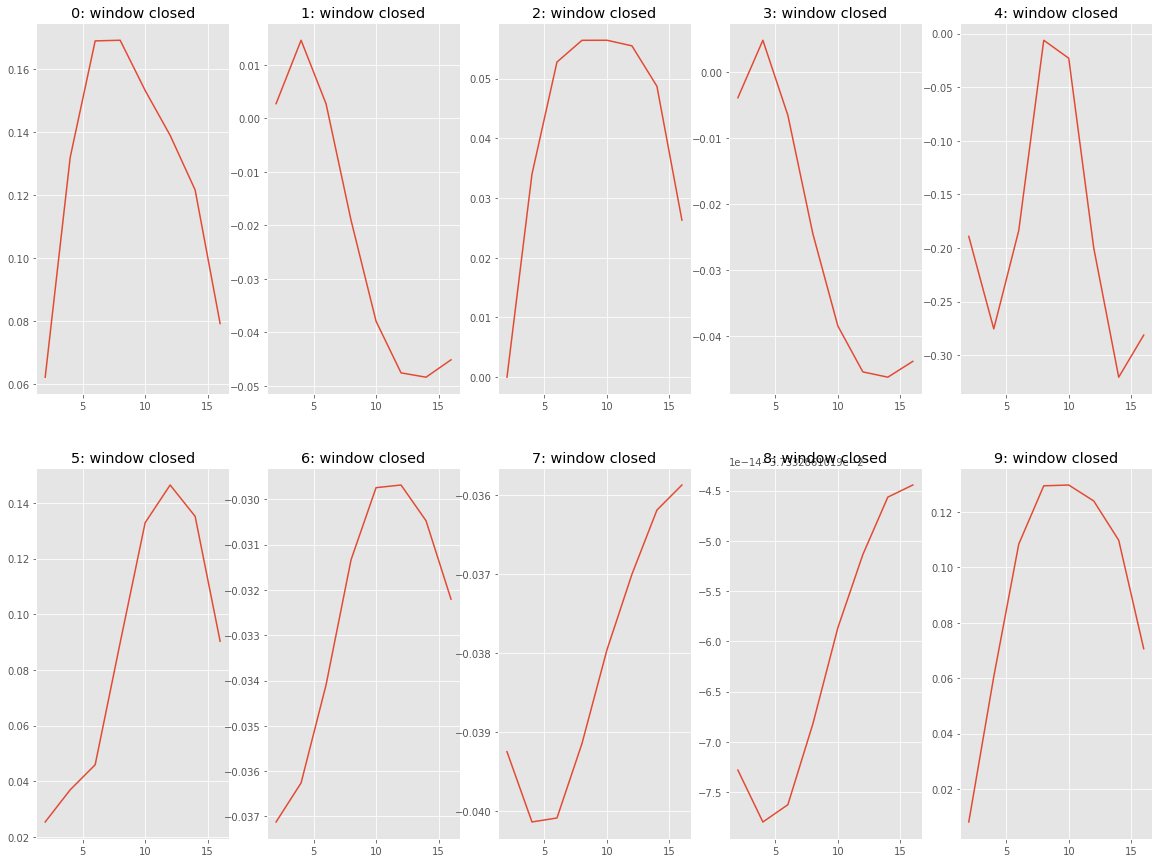

In [243]:
preds = list()
for i in range(10):
    p = rbf.predict(samps[i])
    preds.append(p)

print(preds[0])

plt.figure(figsize=(20,15))

for e in range(10):
    plt.subplot(2,5,e+1)  # 3: number of rows, 4: number of columns, 1: index of the plot (starting from 1), total 12 indices
    plt.title(f"{e}: window closed")
    sns.lineplot(x=[2,4,6,8,10,12,14,16], y=preds[e])

create artificial radiator turnup

In [244]:
# create artificial data to predict from, with 16min

samps = list()

real = df.sample(n=10, random_state=1).drop(["ts"], axis=1).reset_index(drop=True)

for i, e in enumerate(real.iterrows()):
    samp = real.iloc[i].drop(["roomTemp"])
    minCounter = 0
    art = pd.DataFrame(columns=['rad', 'window', 'outTemp', 'outHumid', 'outPressure', 'minutes', 'isWindowChange', 'isRadChange'])
    for u in range(1,9):
        ndf = samp
        ndf["isWindowChange"] = 0
        ndf["isRadChange"] = 1
        ndf["rad"] = 5
        ndf["minutes"] = u*2
        art = art.append(ndf, ignore_index=True)
        
    samps.append(art)

samps[0].head()

,rad,window,outTemp,outHumid,outPressure,minutes,isWindowChange,isRadChange
0,5,True,1.3,94.0,1018.6,2,0,1
1,5,True,1.3,94.0,1018.6,4,0,1
2,5,True,1.3,94.0,1018.6,6,0,1
3,5,True,1.3,94.0,1018.6,8,0,1
4,5,True,1.3,94.0,1018.6,10,0,1


predict & graph

[ 0.01437762  0.0346558   0.02406677 -0.00184277 -0.02586137 -0.04020434
 -0.04489554 -0.04397292]


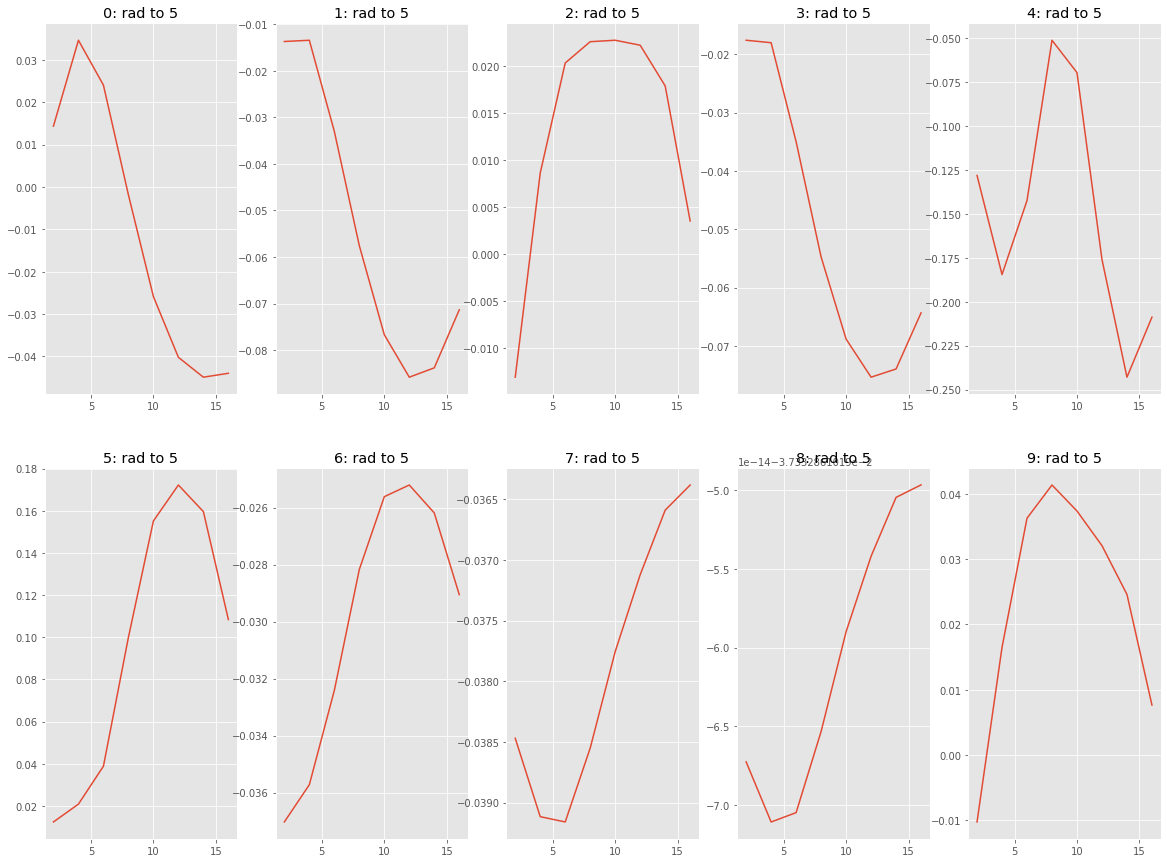

In [245]:
preds = list()
for i in range(10):
    p = rbf.predict(samps[i])
    preds.append(p)

print(preds[0])

plt.figure(figsize=(20,15))

for e in range(10):
    plt.subplot(2,5,e+1)  # 3: number of rows, 4: number of columns, 1: index of the plot (starting from 1), total 12 indices
    plt.title(f"{e}: rad to 5")
    sns.lineplot(x=[2,4,6,8,10,12,14,16], y=preds[e])

create artificial radiator turndown (to 3.5)

In [246]:
# create artificial data to predict from, with 16min

samps = list()

real = df.sample(n=10, random_state=1).drop(["ts"], axis=1).reset_index(drop=True)

for i, e in enumerate(real.iterrows()):
    samp = real.iloc[i].drop(["roomTemp"])
    minCounter = 0
    art = pd.DataFrame(columns=['rad', 'window', 'outTemp', 'outHumid', 'outPressure', 'minutes', 'isWindowChange', 'isRadChange'])
    for u in range(1,9):
        ndf = samp
        ndf["isWindowChange"] = 0
        ndf["isRadChange"] = -1
        ndf["rad"] = 3.5
        ndf["minutes"] = u*2
        art = art.append(ndf, ignore_index=True)
        
    samps.append(art)

samps[0].head()

,rad,window,outTemp,outHumid,outPressure,minutes,isWindowChange,isRadChange
0,3.5,True,1.3,94.0,1018.6,2,0,-1
1,3.5,True,1.3,94.0,1018.6,4,0,-1
2,3.5,True,1.3,94.0,1018.6,6,0,-1
3,3.5,True,1.3,94.0,1018.6,8,0,-1
4,3.5,True,1.3,94.0,1018.6,10,0,-1


predict & graph

[ 0.02742535  0.05282017  0.03955928  0.00711217 -0.02296687 -0.0409289
 -0.0468038  -0.04564838]


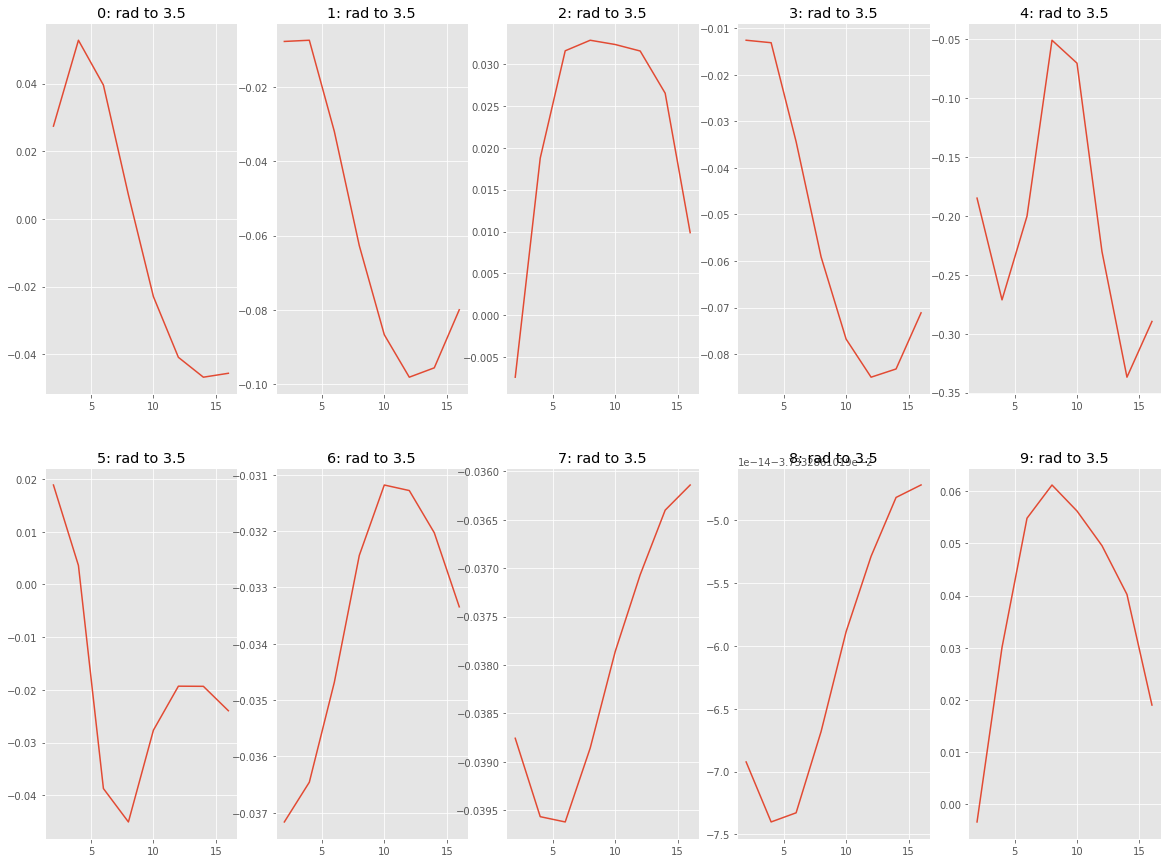

In [247]:
preds = list()
for i in range(10):
    p = rbf.predict(samps[i])
    preds.append(p)

print(preds[0])

plt.figure(figsize=(20,15))

for e in range(10):
    plt.subplot(2,5,e+1)  # 3: number of rows, 4: number of columns, 1: index of the plot (starting from 1), total 12 indices
    plt.title(f"{e}: rad to 3.5")
    sns.lineplot(x=[2,4,6,8,10,12,14,16], y=preds[e])